In [19]:
import pylab as plt
import numpy as np
from cartopy import crs as ccrs
from netCDF4 import Dataset
import xarray as xr
from scipy import ndimage

import sys as sys
import pickle
import glob as glob
import datetime as dt

import swot_ssh_utils as swot
import swot_swell_utils as swell
from  lib_filters_obp import *


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm
import cmocean
import cmocean.cm as cmo

#PATH_with_functions = '/home/ardhuin/TOOLS/OPTOOLS/PYTHON/'
#sys.path.append(PATH_with_functions)
from  spectral_analysis_functions import *
from  wave_physics_functions import *
plt.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

In [39]:
# now repeats the same processing using the newly generated L3 spectra output
cycle='556';tracks='015';figh=5.;latrange=[35,59.6];Lrange=[500,800];Lstep=100;thrange=[180,240];thstep=15;Hrange=[0,0.3];locleg='lower right';ileg=1;  

#cycle='545';tracks='010';latrange=[-45,-30];Lrange=[400,800];Lstep=100;thrange=[180,240];thstep=15;Hrange=[0,7];locleg='upper right';ileg=0;
#cycle='546';tracks='010';latrange=[-45,-30];Lrange=[400,800];Lstep=100;thrange=[180,240];thstep=15;Hrange=[0,3];locleg='lower right';ileg=1;

#cycle='006';tracks='582';latrange=[40,57];Lrange=[600,1100];Lstep=100;thrange=[195,300];thstep=15;Hrange=[0,1.5];locleg='lower right';ileg=0;figh=7;latshift=0;
#cycle='001';tracks='485';latrange=[40,57];Lrange=[600,1100];Lstep=100;thrange=[195,300];thstep=15;Hrange=[0,1.5];locleg='lower right';ileg=0;figh=7;latshift=0;

folder=''
tracktag='cycle '+cycle+', track '+tracks;
modeltag='REF102040' 

print('looking for files:',folder+'SWOT_L3_LR_Spectra_'+cycle+'_'+tracks+'*alpha1.nc' ) 
file_listnc = sorted(glob.glob(folder+'SWOT_L3_LR_Spectra_'+cycle+'_'+tracks+'*alpha1.nc'));

ntrack=int(tracks)
sflip=np.mod(ntrack,2)
print('sflip:',sflip)
L3Snc=xr.open_dataset(file_listnc[0])
modelfound=1
L3S_H18_40=np.squeeze(L3Snc.H18_40.values)
L3S_Hs=np.squeeze(L3Snc.Hs_model.values)
L3S_Tm02=np.squeeze(L3Snc.Tm02_model.values)
timec=L3Snc.time[0].values

L3S_trackangle=np.squeeze(L3Snc.trackangle.values)
[L3Snt,L3Snx]=np.shape(L3S_H18_40)
bigarray_L3S=np.zeros((L3Snt*2,50))
indf=0
L3S_ky2=L3Snc.ky2_40.values
L3S_kx2=L3Snc.kx2_40.values
dkx=L3S_kx2[0,1]-L3S_kx2[0,0]
dky=L3S_ky2[1,0]-L3S_ky2[0,0]

HH=L3Snc.filter_OBP_40.values
HH1=L3Snc.filter_PTR_40.values

# model variables 
modf=L3Snc.frequency.values
moddf=L3Snc.df.values
modang=L3Snc.direction.values
modnth=np.shape(modang)[0]
moddth=(2*np.pi/modnth)


# necessary variables if the SWOT-like spectrum is recomputed ... 
kxmax=-2*L3S_kx2[0,0]
kymax=-2*L3S_ky2[0,0]
[nkyr,nkxr]=np.shape(L3S_kx2)
dkxr=kxmax/nkxr
dkyr=kymax/(nkyr-1)  # only true in nkyr is odd ?? 
kxr=np.linspace(-nkxr*dkxr,(nkxr-1)*dkxr,nkxr*2)
kyr=np.linspace(-nkyr*dkyr,(nkyr-1)*dkyr,nkyr*2)
fx_wreg=kxr*1000
fy_wreg=kyr*1000
kxr2, kyr2 = np.meshgrid(kxr,kyr,indexing='ij') 
kn=np.sqrt(L3S_kx2**2+L3S_ky2**2)*1000
# Defines the spectral response H assocaited to SWOT on board processing and PTR 
x_xt, w_xt, f_xt, H_xt = get_obp_filter(L_filt = 0.980, f_axis = fx_wreg, plot_flag = False, kernel="parzen")
x_at, w_at, f_at, H_at = get_obp_filter(L_filt = 1, f_axis = fy_wreg, plot_flag = False, kernel="bharris")
x_at, w_at, f_obp, H_ptr = get_obp_filter(L_filt = 3, sampling_in = 0.0125,f_axis = fy_wreg, plot_flag = False, kernel="alejandro_azptr")
H = np.repeat(np.array([H_xt]), len(H_at), axis=0).T * np.repeat(np.array([H_at]), len(H_xt), axis=0)
Hptr = np.repeat(np.array([H_ptr]), len(H_xt), axis=0)
H2=H*Hptr                     # note that when model data is also used, H3 is defined below to include az cut-off 

recompute_model_spec=0
# WARNING: not getting exactly the same heights when re-computing ... need to check what is going on with filters and other things ... 

adjust_azc=0;calibration=1;denoise=1;

for indside in range(2): 
  for indt in range(L3Snt): 
    if modelfound > 0 :
      sigu=(L3S_Hs[indt,indside]/4)*(2*np.pi/L3S_Tm02[indt,indside])
      lambdac=1./((7310/875.0e3)/sigu/(2*np.pi))
    else :
      lambdac=3
    Hazc_old =np.exp(-(L3S_ky2*lambdac)**2)
    HH3=HH*HH1*Hazc_old
    Hazc_new = Hazc_old
    L3S_E_SWOT=L3Snc.E_SWOT_40[indt,0,indside,:,:].values
    L3S_amask =L3Snc.mask_40[indt,0,indside,:,:].values

    efth=L3Snc.efth[indt,0,indside,:,:].values

# Alternative: reads spetrum from file ... 
#    indww3=L3Snc.index_model[indt,0,indside].values
#    modspec=ds_ww3t.efth[indww3].squeeze() 
#    efth=modspec.values;

    [Ef,th1m,sth1m,Hs,Tm0m1,Tm02,Qf,Qkk] = wavespec_Efth_to_first3(efth,modf,moddf, modang,moddth,cut=100.) 
    
    sigu3=(Hs/4)*(2*np.pi/Tm02)
    lambdac=1/((7310/875.0e3)/sigu/(2*np.pi))

      
    Hazc = np.exp(-(kyr2*lambdac)**2)        # this is the effect of velocity bunching for sigma0 ... what about the phase? 
    H3=H*Hptr*Hazc
               
    if (recompute_model_spec==1):
       #print('nnn:',indt,kxmax,kymax,dkx,dky,dkxr,dkyr,nkxr,nkyr,sflip,L3S_trackangle[indt],(L3S_trackangle[indt]+sflip*180)*np.pi/180)
       Eta_WW3_obp_H2,Eta_WW3_obp_H,Eta_WW3_noa_H2,Eta_WW3_res,Eta_WW3_c,Ekxky,kxm,kym,ix1,iy1= \
                              swell.wavespec_Efth_to_kxky_SWOT(efth,modf,moddf, modang,moddth,f_xt,f_at,H,Hazc,H3, \
                                            kxmax,kymax,dkx,dky,dkxr,dkyr,nkxr,nkyr,doublesided=0,verbose=0,trackangle=(L3S_trackangle[indt]+sflip*180)*np.pi/180)
        

       if (indt==0):
               dBE=0;dBE2=10;
               vertices=swell.SWOTspec_mask_polygon(Eta_WW3_obp_H2,L3S_amask) 
               fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6,3.5))
               spec = mpl.gridspec.GridSpec(ncols=2, nrows=1,width_ratios=[6, 5])
               plt.subplots_adjust(left=0.05,bottom=0.1, top=0.92,wspace=0.1,right=0.99)
    
# Plotting WW3 spectrum, same resolution as SWOT spectrum 
               im=ax[0].pcolormesh(LS3_kx2*1000,LS3_ky2*1000,10*np.log10(Eta_WW3_obp_H2),cmap='viridis',rasterized=True,vmin = -10+dBE, vmax=30+dBE)
               _=ax[0].set_title('model spectrum  (dB)')
               swell.draw_mask(ax[0],LS3_kx2,dkx,LS3_ky2,dky,vertices,color='w',lw=3) 
                
# Plotting WW3 spectrum, same resolution as SWOT spectrum but 2 x spectral range and no ambiguity in direction 
               im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)
               _=ax[1].set_title('model unfiltered')
               plt.setp(ax[1].get_yticklabels(), visible=False)
               plt.show()

      
    if adjust_azc==1:
        # recomputes sigu (standard dev. of orbital velocity) for a filtered spectrum (cutting at 100 m wavelength) 

        # this was to check that we get the same numbers again ... 
        #[Ef,th1m,sth1m,Hsall,Tm0m1,Tm02all,Qf,Qkk] = wavespec_Efth_to_first3(efth,modf,moddf, modang.values,moddth,cut=10000.) 
    
        [Ef,th1m,sth1m,Hs,Tm0m1,Tm02,Qf,Qkk] = wavespec_Efth_to_first3(efth,modf,moddf, modang.values,moddth,cut=100.) 
    
        sigu3=(Hs/4)*(2*np.pi/Tm02)
        
        lambdac=1./((7310/875.0e3)/sigu3/(2*np.pi))
        Hazc_new =np.exp(-(L3S_ky2*lambdac)**2)
        
    HHC=(HH1)**calibration  # calibration of the PTR
    HH3=HH*HHC*(Hazc_new/Hazc_old)  # filter corrected with calibration for Hptr and new cut-off for Hazc. 
    
    # NB: to be fully correct we should also redo the aliasing calculation with the updated filter ...
    bigarray_L3S[indf,0]=L3Snc.time[indt].values
    bigarray_L3S[indf,1]=L3Snc.longitude_40[indt,0,indside].values
    bigarray_L3S[indf,2]=L3Snc.latitude_40[indt,0,indside].values
    bigarray_L3S[indf,3]=L3Snc.time_model[indt,0,indside].values
    bigarray_L3S[indf,4]=lambdac
    
    Hsnew,Lmm1new,Lmnew,dmnew,Q18=swell.SWOTspec_to_HsLm(L3S_E_SWOT,L3S_kx2,L3S_ky2,L3S_amask,HH3,L3S_trackangle[indt])
    bigarray_L3S[indf,10]=Hsnew
    #bigarray_L3S[indf,10]=L3Snc.H18_40[indt,0,indside].values
    bigarray_L3S[indf,20]=Lmm1new
    bigarray_L3S[indf,30]=dmnew

    dkx=L3S_kx2[0,1]-L3S_kx2[0,0]

      
    if (denoise==1):
       Ekth,kn1,theta1,Eta_SWOT_nonoise=swell.SWOT_denoise_isotropic(L3S_E_SWOT/HH3,L3S_kx2,L3S_ky2)
       Hsnew,Lmm1new,Lmnew,dmnew,Q18=swell.SWOTspec_to_HsLm(Eta_SWOT_nonoise,L3S_kx2,L3S_ky2,L3S_amask,(HH3*0+1),L3S_trackangle[indt])
       bigarray_L3S[indf,12]=Hsnew
       bigarray_L3S[indf,22]=Lmm1new
       bigarray_L3S[indf,32]=dmnew
    
    
    b2mask=L3S_amask
# uses a slightly wider mask for the model to be sure to catch the full partition 
    #b2mask=ndimage.binary_dilation((L3S_amask > 0.5).astype(int))
    #
    bigarray_L3S[indf,11]=L3Snc.H18_model[indt,0,indside].values 
    bigarray_L3S[indf,21]=L3Snc.L18_model[indt,0,indside].values 
    bigarray_L3S[indf,31]=L3Snc.d18_model[indt,0,indside].values
# recomputes parameters from resampled model spectrum 
    if (recompute_model_spec==1): 
        Hsnew,Lmm1new,Lmnew,dmnew,Q18=swell.SWOTspec_to_HsLm(Eta_WW3_obp_H2,L3S_kx2,L3S_ky2,b2mask,HH3,trackangle)
#    bigarray_L3S[indf,11]=Hsnew 
#    bigarray_L3S[indf,21]=Lmm1new 
#    bigarray_L3S[indf,31]=dmnew 

      
    indf=indf+1
L3Snc.close()  # close the L3 spectra file

looking for files: SWOT_L3_LR_Spectra_556_015*alpha1.nc
sflip: 1


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:101: RuntimeWarning: overflow encountered in square
  Q1[ind]=np.sum(eftn[ind,:]**2)*dth
/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:105: RuntimeWarning: overflow encountered in square
  Qf=np.sqrt(np.sum(Ef**2*dfreq))/Etot


size of arrays: 149


/tmp/ipykernel_1174365/1180023971.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(bigarray_L3S[s1:-1,10],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
/tmp/ipykernel_1174365/1180023971.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(bigarray_L3S[s1:-1,20],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
/tmp/ipykernel_1174365/1180023971.py:59: UserWarni

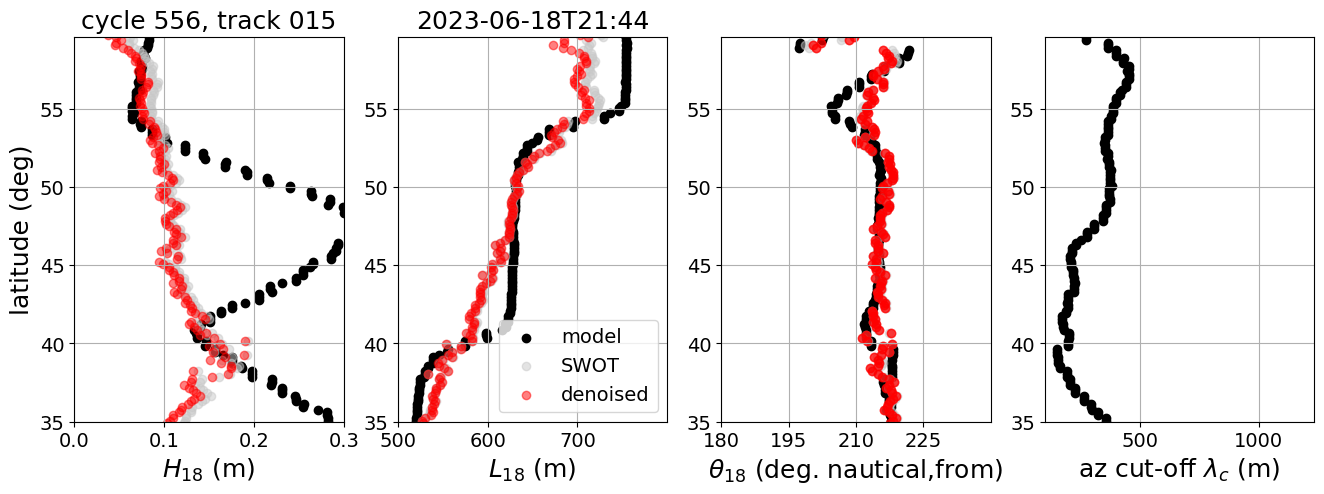

In [41]:
gr=[0.,205./255.,0.]
fig,axs=plt.subplots(1,4,figsize=(16,figh))
vecHs=np.linspace(1,12,23)
s1=indt # for right swath only 
print('size of arrays:',indt) 


if s1 < indt  :
   axs[0].scatter(bigarray[0:nfiles,11],bigarray[0:nfiles,2],c='black',linewidth=1,label='model left');
   axs[0].scatter(bigarray[nfiles+1:-1,11],bigarray[nfiles+1:-1,2],c='blue',linewidth=1,label='model  right');
   axs[0].scatter(bigarray[nfiles+1:-1,10],bigarray[nfiles+1:-1,2],c=gr,linewidth=1,label='SWOT  right');
   axs[0].scatter(bigarray[0:nfiles,10],bigarray[0:nfiles,2],c='red',linewidth=1,label='SWOT left');
else: 
   gr=[200./255.,200./255.,200./255.]
   gS=[80./255.,255./255.,80./255.]
   axs[0].scatter(bigarray_L3S[s1:-1,11],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model');
   axs[0].scatter(bigarray_L3S[s1:-1,10],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
   if (denoise==1):
      axs[0].scatter(bigarray_L3S[s1:-1,12],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');
   
    
axs[0].set_xlabel(r'$H_{18}$ (m)', fontsize=18)
axs[0].set_ylabel('latitude (deg)', fontsize=18)
axs[0].set_title(tracktag, fontsize=18)
axs[0].set_xlim(Hrange);
#axs[0].set_xlim([0,5]);
axs[0].set_ylim(latrange)

if s1 < indt  :
   axs[1].scatter(bigarray[0:nfiles,21],bigarray[0:nfiles,2],c='black',linewidth=1,label='model left');
   axs[1].scatter(bigarray[nfiles+1:-1,21],bigarray[nfiles+1:-1,2],c='blue',linewidth=1,label='model  right');
   axs[1].scatter(bigarray[nfiles+1:-1,20],bigarray[nfiles+1:-1,2],c=gr,linewidth=1,label='SWOT  right');
   axs[1].scatter(bigarray[0:nfiles,20],bigarray[0:nfiles,2],c='red',linewidth=1,label='SWOT left');
else: 
   axs[1].scatter(bigarray_L3S[s1:-1,21],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model');
   axs[1].scatter(bigarray_L3S[s1:-1,20],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT'); 
   if (denoise==1):
      axs[1].scatter(bigarray_L3S[s1:-1,22],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');

axs[1].set_xlabel(r'$L_{18}$ (m)', fontsize=18)
format = '%Y-%m-%dT%H:%M:%S'
axs[1].set_title(str(timec)[0:16], fontsize=18)
axs[1].set_xlim(Lrange)
axs[1].set_xticks(np.arange(Lrange[0],Lrange[1],Lstep))
#axs[1].set_xlim([450,650])
#axs[1].set_xticks(np.arange(450,650,50))
axs[1].set_ylim(latrange)
leg = axs[ileg].legend(loc=locleg, fontsize=14)

lightcmap = cmocean.tools.lighten(cmo.ice_r, 0.5)

if s1 < indt  :
   axs[2].scatter(bigarray[0:nfiles,31],bigarray[0:nfiles,2],c='black',linewidth=1,label='model left');
   axs[2].scatter(bigarray[nfiles+1:-1,31],bigarray[nfiles+1:-1,2],c='blue',linewidth=1,label='model right');
   axs[2].scatter(bigarray[nfiles+1:-1,30],bigarray[nfiles+1:-1,2],c=gr,linewidth=1,label='SWOT right');
   axs[2].scatter(bigarray[0:nfiles,30],bigarray[0:nfiles,2],c='red',linewidth=1,label='SWOT left');
else: 
   axs[2].scatter(bigarray_L3S[s1:-1,31],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model');
   axs[2].scatter(bigarray_L3S[s1:-1,30],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
   if (denoise==1):
     axs[2].scatter(bigarray_L3S[s1:-1,32],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');
     axs[2].scatter(bigarray_L3S[s1:-1,32],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');

axs[2].set_xlabel(r'$\theta_{18}$ (deg. nautical,from)', fontsize=18)
axs[2].set_xlim(thrange)
axs[2].set_xticks(np.arange(thrange[0],thrange[1],thstep))
axs[2].set_ylim(latrange)
#axs[2].set_title(tracktag)

if s1 < indt  :
   axs[3].scatter(bigarray[0:nfiles,4],bigarray[0:nfiles,2],c='black',linewidth=1,label='model left');
   axs[3].scatter(bigarray[nfiles+1:-1,4],bigarray[nfiles+1:-1,2],c='blue',linewidth=1,label='model right');
else: 
   axs[3].scatter(bigarray_L3S[s1:-1,4],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model');

axs[3].set_xlabel(r'az cut-off $\lambda_c$ (m)', fontsize=18)    
axs[3].set_ylim(latrange)
fig.savefig('fulltrack_'+str(cycle)+'_'+str(tracks)+'_H2azc_cal'+modeltag+f'{abs(calibration):03.1f}'+'L3.pdf')
       